In [ ]:
# import all necessary dependencies
import os
import re
import itertools
import pandas as pd
import networkx as nx
from tqdm import tqdm
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
tqdm.pandas()

drive.mount('/content/drive')
%cd /content/drive/Shareddrives/Comsci Studio 1 GROUP 5/ComsciStudio1/Colab Notebooks

"""

WRITE YOUR OWN ODE HERE:

Upload your downloaded files to Google Drive and connect to your Google Drive target folder.

Then read all the files and concatenate them into a single dataframe - df, then remove records that have no abstracts

"""

file_folder = '/content/drive/Shareddrives/Comsci Studio 1 GROUP 5/ComsciStudio1/Colab Notebooks/data'
data = pd.concat([pd.read_csv(os.path.join(file_folder, file), sep='\t') for file in os.listdir(file_folder)]).reset_index()

# remove records that have no abstracts
data = data.dropna(subset=['AB'])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/Comsci Studio 1 GROUP 5/ComsciStudio1/Colab Notebooks


In [ ]:
# find doi from cited reference list string
def find_doi(row):
    crs = str(row['CR']).split(';')
    doi_pattern = r'10\.\d{4,9}/[-._;()/:A-Z0-9]+'
    found_dois = [re.findall(doi_pattern, _, re.IGNORECASE) for _ in crs]
    found_dois = [list(set(_))[0].lower() if _ else None for _ in found_dois]
    return found_dois

In [ ]:
# run and return the found citing lists as lists
data['CR_DOI'] = data.progress_apply(find_doi, axis=1)

100%|██████████| 2619/2619 [00:00<00:00, 6255.94it/s]


In [ ]:
print(data[['DI', 'CR_DOI']].head()) # Inspect the first few rows of these columns
print(data['DI'].isnull().sum())     # Check for missing values in 'DOI'
print(data['CR_DOI'].isnull().sum())   # Check for missing values in 'CR_DOI'

                                DI  \
0  10.1109/IJCC64742.2024.10847270   
1               10.1117/12.2622727   
2       10.1186/s13635-024-00152-9   
3         10.32604/cmc.2023.036894   
4                              NaN   

                                              CR_DOI  
0  [10.1016/j.procs.2021.03.107, 10.1109/iacs.201...  
1  [None, 10.1016/s1353-4858(16)30086-1, 10.1109/...  
2  [10.18196/jrc.2150, 10.17762/turcomat.v12i10.4...  
3  [None, 10.1155/2022/1862888, 10.1109/comst.202...  
4  [10.1109/jiot.2024.3354045, 10.3390/s23218959,...  
298
0


In [ ]:
# build a direct citation graph
G = nx.DiGraph()

"""

WRITE YOUR OWN CODE HERE

construct a directed citation graph, use doi as node labels, df['DI'] is the citing doi, df['CR_DOI'] is the cited list

"""

for a,b in zip(data['DI'], data['CR_DOI']):
  for cited_ref in b:
    if a and cited_ref:
      G.add_edge(cited_ref,a)

# #remove cycles in the constructed graph
cycles = list(nx.simple_cycles(G))
G.remove_edges_from([cycle if len (cycle) == 2 else (cycle[0], cycle[0]) for cycle in cycles])
print(G)


DiGraph with 41558 nodes and 68113 edges


In [ ]:
# @title Default title text
def extract_main_path(G: nx.DiGraph, top_k=10):
    """
    top_k is the most important k nodes involved on the main paths.
    Computes the Search Path Link Count (SPLC) for each edge in a directed acyclic citation graph (DAG) G.
    Assumes that every edge has equal weight (1).
    Returns:
        A: dict mapping each node to the number of paths from sources to that node.
        B: dict mapping each node to the number of paths from that node to sinks.
        splc: dict mapping each edge (u, v) to its SPLC value.
        sub_graph: subgraph of G that contains top k (default 10) important nodes and their relevant citation paths.
    """

    if len(G) < top_k:
      print("The citation graph is too small to analyse.")
      return None, None, None, None

    # Identify source (no incoming edges) and sink nodes (no outgoing edges)
    sources = [n for n in G.nodes if G.in_degree(n) == 0]
    sinks   = [n for n in G.nodes if G.out_degree(n) == 0]

    # A: Number of paths from any source to node n
    A = {n: 0 for n in G.nodes}
    for s in sources:
        A[s] = 1

    # Process nodes in topological order
    for node in nx.topological_sort(G):
        for succ in G.successors(node):
            A[succ] += A[node]

    # B: Number of paths from node n to any sink
    B = {n: 0 for n in G.nodes}
    for t in sinks:
        B[t] = 1

    for node in reversed(list(nx.topological_sort(G))):
        for pred in G.predecessors(node):
            B[pred] += B[node]

    # Compute SPLC for each edge (u, v) as A[u] * B[v]
    splc = {}
    for u, v in G.edges():
        splc[(u, v)] = A[u] * B[v]

    # select the top k nodes
    top_paths = []
    top_nodes = list(set(itertools.chain.from_iterable(top_paths)))
    i = 0
    while len(top_nodes) < top_k:
        top_paths = sorted(splc.keys(),key=lambda x: splc[x], reverse=True)[:i]
        top_nodes = list(set(itertools.chain.from_iterable(top_paths)))
        i += 1

    sub_graph = nx.DiGraph()
    sub_graph.add_edges_from(top_paths)

    return A, B, splc, sub_graph

In [ ]:
#This code cell is to remove unrelated documents
# Calculate the 90th percentile of SPLC values
degree_centrality = nx.degree_centrality(G)
threshold = np.percentile(list(degree_centrality.values()), 70)  # Adjust percentile as needed
relevant_nodes = [node for node, centrality in degree_centrality.items() if centrality >= threshold]

# Remove nodes from G based on relevance threshold
nodes_to_remove = set(G.nodes()) - set(relevant_nodes)
G.remove_nodes_from(nodes_to_remove)
print (G)

# Identify and remove rows from data based on filtered G
rows_to_remove = ~data['DI'].isin(list(G.nodes()))
data = data[~rows_to_remove]

import re

def is_phishing_related(text):
    keywords = ["URL", "url", "URLs", "urls"]
    pattern = "|".join(keywords)  # Create a regex pattern
    return bool(re.search(pattern, text, re.IGNORECASE))

# Apply the function to the 'TI' (title) and 'AB' (abstract) columns
phishing_related_mask = data.apply(lambda row: is_phishing_related(str(row['TI'])) or is_phishing_related(str(row['AB'])), axis=1)
print(phishing_related_mask)
print (G)
# Filter the DataFrame
data = data[~phishing_related_mask]

DiGraph with 898 nodes and 7760 edges
3       False
4       False
6       False
8       False
10      False
        ...  
2603    False
2613    False
2618    False
2619    False
2622    False
Length: 673, dtype: bool
DiGraph with 898 nodes and 7760 edges


In [ ]:
# splc
A, B, splc, main_graph = extract_main_path(G)

[57, 152, 78, 34, 51, 12, 41, 21, 30, 22, 53]
['10.1007/s11235-017-0414-0', '10.1016/j.eswa.2018.09.029', '10.1016/j.ins.2019.01.064', '10.1007/s00521-016-2275-y', '10.1186/s13635-016-0034-3', '10.1007/s12652-017-0616-z', '10.1007/s11235-017-0334-z', '10.1016/j.cose.2017.12.006', '10.3390/s19194258', '10.1016/j.procs.2020.02.251', '10.1007/s11235-020-00733-2']


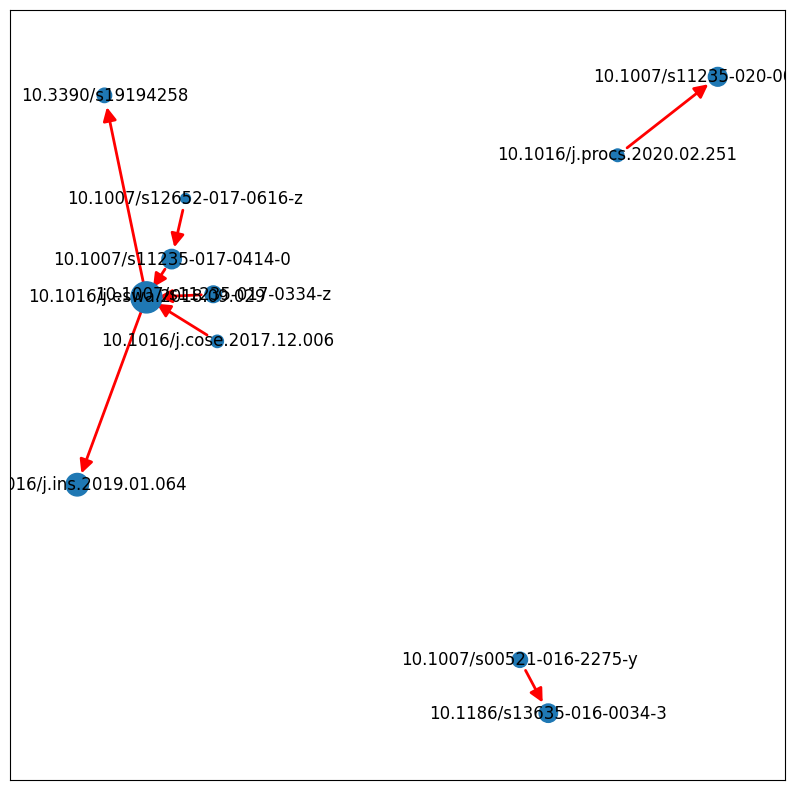

In [ ]:
# visualize the graph
pos = nx.spring_layout(main_graph, seed=20)
plt.figure(figsize=(10, 10))
node_size = [G.out_degree(u) for u in main_graph.nodes]
print(node_size)
print(list(main_graph.nodes))
normalized_node_size = [(_ - min(node_size))/(max(node_size) - min(node_size)) * 450 + 50 for _ in node_size]
nx.draw_networkx_nodes(main_graph, pos, node_size=normalized_node_size)
nx.draw_networkx_labels(main_graph, pos)
non_highlighted_edges = [edge for edge in G.subgraph(main_graph.nodes).edges() if edge not in main_graph.edges()]
nx.draw_networkx_edges(main_graph, pos, edgelist=main_graph.edges(), edge_color='red', width=2, arrowsize=20)

In [ ]:
top_10_nodes = list(main_graph.nodes())[:10]


In [ ]:
relevant_papers = data[data['DI'].isin(top_10_nodes)][['DI','PY', 'JI', 'TI', 'AB', 'TC']]

In [ ]:
from IPython.display import display

display(relevant_papers)

,DI,PY,JI,TI,AB,TC
310,10.1016/j.ins.2019.01.064,2019.0,Inf. Sci.,A new hybrid ensemble feature selection framew...,This paper proposes a new feature selection fr...,180
645,10.1016/j.procs.2020.02.251,2020.0,NaN,Comparison of Adaboost with MultiBoosting for ...,Developments in the Internet introduced new tr...,34
1079,10.1007/s12652-017-0616-z,2018.0,J. Ambient Intell. Humaniz. Comput.,Two-level authentication approach to protect f...,"Nowadays, the phishing attack is emerging as s...",34
1116,10.1016/j.cose.2017.12.006,2018.0,Comput. Secur.,Mobile phishing attacks and defence mechanisms...,Phishing is an online identity theft in which ...,85
1291,10.1007/s11235-017-0334-z,2018.0,Telecommun. Syst.,Defending against phishing attacks: taxonomy o...,"Internet technology is so pervasive today, for...",127
1414,10.1007/s00521-016-2275-y,2017.0,Neural Comput. Appl.,Fighting against phishing attacks: state of th...,"In the last few years, phishing scams have rap...",121
1418,10.1186/s13635-016-0034-3,2016.0,EURASIP J. Inf. Secur.,A novel approach to protect against phishing a...,Most of the anti-phishing solutions are having...,112


In [ ]:
from IPython.display import display

# Assuming you have 'top_10_nodes' and 'data' DataFrame available
top_10_papers = data[data['DI'].isin(top_10_nodes)]
display(top_10_papers)

,index,PT,AU,BA,BE,GP,AF,BF,CA,TI,...,WE,SC,GA,PM,OA,HC,HP,DA,UT,CR_DOI
58,58,J,"Wei, B; Hamad, RA; Yang, LZ; He, X; Wang, H; G...",NaN,NaN,NaN,"Wei, Bo; Hamad, Rebeen Ali; Yang, Longzhi; He,...",NaN,NaN,A Deep-Learning-Driven Light-Weight Phishing D...,...,Science Citation Index Expanded (SCI-EXPANDED),Chemistry; Engineering; Instruments & Instrume...,JK4OO,31575038,"Green Published, gold, Green Accepted, Green S...",NaN,NaN,2025-04-17,WOS:000494823200202,"[10.1109/tmc.2016.2575828, None, None, None, 1..."
68,68,J,"Sahingoz, OK; Buber, E; Demir, O; Diri, B",NaN,NaN,NaN,"Sahingoz, Ozgur Koray; Buber, Ebubekir; Demir,...",NaN,NaN,Machine learning based phishing detection from...,...,Science Citation Index Expanded (SCI-EXPANDED),Computer Science; Engineering; Operations Rese...,HA0IP,NaN,NaN,Y,N,2025-04-17,WOS:000449892000024,"[None, None, None, None, None, 10.1007/s00500-..."
310,310,J,"Chiew, KL; Tan, CL; Wong, K; Yong, KSC; Tiong, WK",NaN,NaN,NaN,"Chiew, Kang Leng; Tan, Choon Lin; Wong, KokShe...",NaN,NaN,A new hybrid ensemble feature selection framew...,...,Science Citation Index Expanded (SCI-EXPANDED),Computer Science,HP1FL,NaN,Green Accepted,NaN,NaN,2025-04-17,WOS:000461410700010,"[10.1016/j.eswa.2014.03.019, 10.1109/mcit.2010..."
335,335,J,"Jain, AK; Gupta, BB",NaN,NaN,NaN,"Jain, Ankit Kumar; Gupta, B. B.",NaN,NaN,Towards detection of phishing websites on clie...,...,Science Citation Index Expanded (SCI-EXPANDED),Telecommunications,GK8FA,NaN,NaN,NaN,NaN,2025-04-17,WOS:000436452400007,"[10.1109/surv.2013.030713.00020, None, None, 1..."
645,645,C,"Subasi, A; Kremic, E",NaN,"KilicayErgin, N; Dagli, CH",NaN,"Subasi, Abdulhamit; Kremic, Emir",NaN,NaN,Comparison of Adaboost with MultiBoosting for ...,...,Conference Proceedings Citation Index - Scienc...,Computer Science; Operations Research & Manage...,BQ3BA,NaN,gold,NaN,NaN,2025-04-17,WOS:000583734400036,"[10.1016/j.eswa.2010.04.044, 10.1109/tim.2018...."
1079,79,J,"Jain, AK; Gupta, BB",NaN,NaN,NaN,"Jain, Ankit Kumar; Gupta, B. B.",NaN,NaN,Two-level authentication approach to protect f...,...,Science Citation Index Expanded (SCI-EXPANDED),Computer Science; Telecommunications,GW2QT,NaN,NaN,NaN,NaN,2025-04-17,WOS:000446730900005,"[None, None, None, None, None, None, None, Non..."
1116,116,J,"Goel, D; Jain, AK",NaN,NaN,NaN,"Goel, Diksha; Jain, Ankit Kumar",NaN,NaN,Mobile phishing attacks and defence mechanisms...,...,Science Citation Index Expanded (SCI-EXPANDED),Computer Science,FW8GO,NaN,NaN,NaN,NaN,2025-04-17,WOS:000425569100033,"[10.1109/glocom.2008.ecp.386, None, 10.1016/j...."
1291,291,J,"Gupta, BB; Arachchilage, NAG; Psannis, KE",NaN,NaN,NaN,"Gupta, B. B.; Arachchilage, Nalin A. G.; Psann...",NaN,NaN,Defending against phishing attacks: taxonomy o...,...,Science Citation Index Expanded (SCI-EXPANDED)...,Telecommunications,FT4RN,NaN,Green Submitted,NaN,NaN,2025-04-17,WOS:000423142500008,"[10.1109/itng.2010.117, None, None, 10.17485/i..."
1414,414,J,"Gupta, BB; Tewari, A; Jain, AK; Agrawal, DP",NaN,NaN,NaN,"Gupta, B. B.; Tewari, Aakanksha; Jain, Ankit K...",NaN,NaN,Fighting against phishing attacks: state of th...,...,Science Citation Index Expanded (SCI-EXPANDED),Computer Science,FJ6CU,NaN,NaN,NaN,NaN,2025-04-17,WOS:000412842200001,"[10.1109/itng.2010.117, None, 10.3923/jas.2011..."
1418,418,J,"Jain, AK; Gupta, BB",NaN,NaN,NaN,"Jain, Ankit Kumar; Gupta, B. B.",NaN,NaN,A novel approach to protect against phishing a...,...,Emerging Sources Citation Index (ESCI),Computer Science,EB5KS,NaN,hybrid,NaN,NaN,2025-04-17,WOS:000387413800001,"[10.17485/ijst/2013/v6i1.18, 10.1109/surv.2013..."
